In [3]:
!pip install opencv-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 22.4 MB/s eta 0:00:0000:0100:01


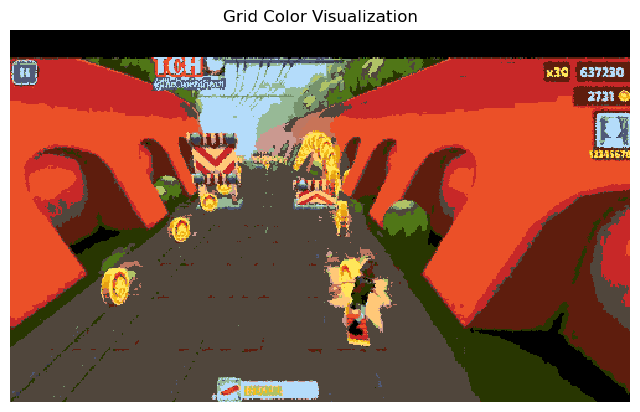

In [90]:
import cv2
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

# 1) Configuration
IMG_PATH = "test2.png"
GRID_W, GRID_H = 500, 300

PALETTE = {
    # Sky / ground 
    (134,109,77) : 1,
    (171,148,115) : 1, #Dusty CUSTOM
    (180, 220, 250): 0,
    (145,  90,  55): 1,
    (80,   70,  60): 1, #KEYYYY
    # Obstacles
    (235,  60,  60): 2,
    (200,  40,  40): 3,
    # Coins / glow
    (255, 215,   0): 4,
    (255, 200, 120): 5,
    # Train yellows
    (255, 230,  90): 6,
    (245, 190,  30): 7,
    (230, 160,  20): 8,
    # Train metal
    (80,   90, 120): 9,
    (60,   60,  80): 10,
    # Map/terrain
    (235,  80,  40): 11,
    (40,   54,   1): 12,
    (50,  110,  50): 13,

    (0, 0 ,0) : 14,

    #Custom additions
    (202,153,144) : 16,
    (151,185,150) : 17,
    (80,118,23) : 18,
    (176,194,102) : 19,
    (200,116,88) : 20,
    (189,119,98) : 21,
    (94,29,13) : 22,
    (118,146,108) : 23,
}

def nearest_color_label(rgb, palette):
    best_key, best_dist = None, float("inf")
    for key, label in palette.items():
        d = sum((rgb[i] - key[i])**2 for i in range(3))
        if d < best_dist:
            best_dist, best_key = d, key
    return palette[best_key]

# ←— START OF INSERTED BLOCK —→
# Load & prepare image
img = cv2.imread(IMG_PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Compute cell dimensions
h_img, w_img, _ = img.shape
cell_w = w_img // GRID_W
cell_h = h_img // GRID_H

# Initialize label‐grid
grid = np.zeros((GRID_H, GRID_W), dtype=np.int32)
# ←— END OF INSERTED BLOCK —→

# 2) Fill grid with labels
for row in range(GRID_H):
    for col in range(GRID_W):
        x0, y0 = col * cell_w, row * cell_h
        x1, y1 = x0 + cell_w, y0 + cell_h
        cell = img[y0:y1, x0:x1]

        flat = cell.reshape(-1, 3)
        mode_rgb, _ = Counter(map(tuple, flat)).most_common(1)[0]
        grid[row, col] = nearest_color_label(mode_rgb, PALETTE)

# 3) Build label→RGB map
color_map = {v: tuple(c/255 for c in k) for k, v in PALETTE.items()}

# 4) Visualize
h, w = grid.shape
vis = np.zeros((h, w, 3))
for label, color in color_map.items():
    vis[grid == label] = color

plt.figure(figsize=(8, 5))
plt.imshow(vis, interpolation='nearest')
plt.axis('off')
plt.title("Grid Color Visualization")
plt.show()


In [91]:
import cv2
import numpy as np

def recolor_road_from_grid_strict(img_rgb, grid, target_color=(0,200,0)):
    """
    Recolor **only** the largest contiguous ground-run on each scanline,
    turning it neon green.  This follows curved roads naturally.
    
    Args:
      img_rgb:      H×W×3 RGB uint8 image.
      grid:         (GH×GW) int array with your labels (1 == road ground).
      target_color: (R,G,B) tuple for the neon fill.
    
    Returns:
      out:          H×W×3 RGB uint8 with only the true road recolored.
    """
    H, W = img_rgb.shape[:2]
    GH, GW = grid.shape
    cell_h = H // GH
    cell_w = W // GW

    # 1) Upsample grid→pixel ground mask
    ground_mask = np.zeros((H, W), dtype=bool)
    for ry in range(GH):
        y0 = ry * cell_h
        y1 = y0 + cell_h
        for cx in range(GW):
            if grid[ry, cx] == 1:
                x0 = cx * cell_w
                x1 = x0 + cell_w
                ground_mask[y0:y1, x0:x1] = True

    # 2) Build the “strict road” mask row by row
    strict_mask = np.zeros_like(ground_mask)
    for y in range(H):
        xs = np.where(ground_mask[y])[0]
        if xs.size == 0:
            continue
        # split into runs where diff > 1
        splits = np.where(np.diff(xs) > 1)[0] + 1
        segments = np.split(xs, splits)
        # pick the longest segment
        longest = max(segments, key=len)
        strict_mask[y, longest] = True

    # 3) Optional: close small holes so you don’t leave speckles
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    strict_mask = cv2.morphologyEx(strict_mask.astype(np.uint8),
                                   cv2.MORPH_CLOSE,
                                   kernel).astype(bool)

    # 4) Recolor
    out = img_rgb.copy()
    out[strict_mask] = target_color
    return out


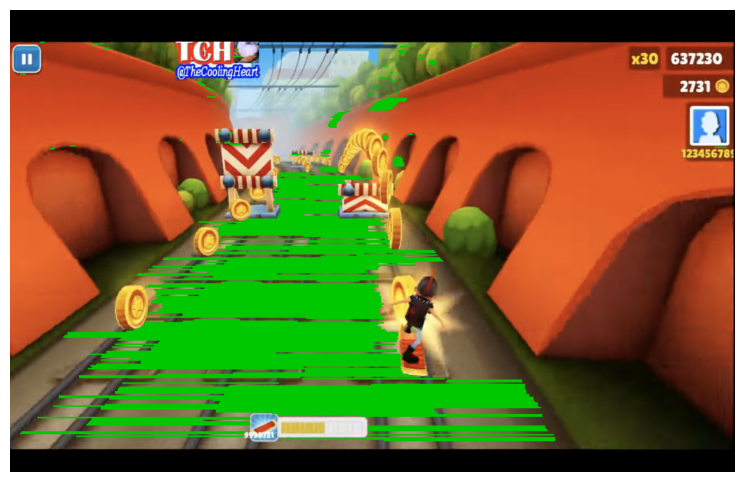

In [92]:
# … after you’ve computed `img` (RGB) and `grid` …
final = recolor_road_from_grid_strict(img, grid, target_color=(0,200,0))

import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.imshow(final)
plt.axis('off')
plt.show()


In [93]:
import cv2
import numpy as np

def fast_label_grid(img, palette, grid_w, grid_h):
    """
    Load an RGB image → downsample to (grid_w×grid_h) → map each
    cell’s representative pixel to the nearest palette label in one shot.
    """
    # 1) AREA‐downsample to grid size
    small = cv2.resize(img, (grid_w, grid_h), interpolation=cv2.INTER_AREA)

    # 2) flatten pixels & palette into arrays
    pixels = small.reshape(-1, 3).astype(np.int16)                    # (grid_w*grid_h, 3)
    keys   = np.array(list(palette.keys()),   dtype=np.int16)         # (Nkeys, 3)
    vals   = np.array(list(palette.values()), dtype=np.int32)         # (Nkeys,)

    # 3) compute squared‐Euclidean distance from each pixel to each key
    #    → shape (grid_w*grid_h, Nkeys)
    dists  = ((pixels[:, None, :] - keys[None, :, :])**2).sum(axis=2)

    # 4) pick nearest key → reconstruct grid
    best   = np.argmin(dists, axis=1)                                 # (grid_w*grid_h,)
    grid   = vals[best].reshape(grid_h, grid_w)                       # (grid_h, grid_w)

    return grid

# ——— example self‐call ———
IMG_PATH = "test2.png"
GRID_W, GRID_H = 500, 300

# (Assume PALETTE is defined as in your code above)
img  = cv2.imread(IMG_PATH)
img  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

grid = fast_label_grid(img, PALETTE, GRID_W, GRID_H)

# now `grid` is your speed‐optimized label matrix


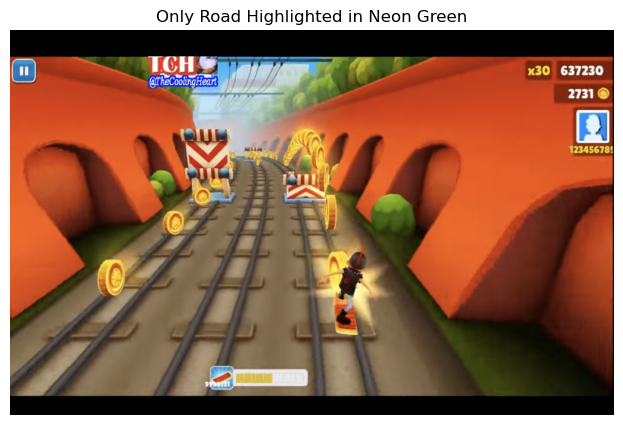

In [98]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1) Configuration
IMG_PATH = "test2.png"
TARGET_COLOR = (0,200,0)    # neon green

PALETTE = {
    # (R,G,B) : label
    (134,109,77) : 1,
    (171,148,115): 1,
    (145,  90,  55): 1,
    (91,80,76): 1,
    # … your other palette entries …
}

def overlay_road_mask(img, palette, target_color=(0,200,0), do_close=True):
    """
    1) Build a mask of all pixels whose exact RGB matches any 'road' color in palette.
    2) (Optional) Close tiny holes with a 5×5 rectangle.
    3) Recolor masked pixels to target_color.
    """
    # a) collect all road‐colors into an array
    road_keys = np.array([c for c,l in palette.items() if l == 1], dtype=np.uint8)  # (Nroad,3)

    # b) mask = any( pixel == one of the road_keys )
    #      img shape = (H,W,3), broadcast road_keys over (H,W)
    mask = np.any(
        np.all(img[None, ...] == road_keys[:, None, None, :], axis=-1),
        axis=0
    )  # → shape (H,W), bool

    # c) optional: close small holes so you don’t get speckles
    if do_close:
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
        mask = cv2.morphologyEx(mask.astype(np.uint8),
                                cv2.MORPH_CLOSE,
                                kernel).astype(bool)

    # d) overlay neon green
    out = img.copy()
    out[mask] = target_color
    return out

# ——— self‐call & visualize ———
img_bgr = cv2.imread(IMG_PATH)
img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

result = overlay_road_mask(img, PALETTE, TARGET_COLOR)

plt.figure(figsize=(8,5))
plt.imshow(result)
plt.axis('off')
plt.title("Only Road Highlighted in Neon Green")
plt.show()
